# Compute percentiles on the trends for both regional and spatial processed data

### Imports

In [1]:
import glob
import os
import numpy as np
import xarray as xr

%matplotlib inline

### Define functions

In [2]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [3]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

In [4]:
def percentile_vec_mult(data,core_dims:list,q,**kwargs):
    '''
    Handle multiple core dimensions.
    '''
    chunk_dict = {}
    for i in core_dims:
        chunk_dict[i] = -1
    
    data_chunk = data.chunk(chunk_dict) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[core_dims],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

### Load and process regional trend data

#### Models

In [5]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
obsle_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/'
spatial_5x5deg_subdir = 'TREFHT_5x5deg_AnnualTrends'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [6]:
os.listdir(obsle_tseries_dir)

['TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1950.nc',
 'TREFHT_DJF_1921-2014_ensmem1-1000.5x5deg.nc',
 'TREFHT_SON_1921-2014_ensmem1-1000.5x5deg.nc',
 'TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950.nc',
 'TREFHT_JJA_1921-2014_ensmem1-1000.5x5deg.nc',
 'TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950.Percentiles.nc',
 'TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1922.nc',
 'TREFHT_SON_1921-2014_ensmem1-1000.IPCCregions.nc',
 'TREFHT_Annual_1921-2014_ensmem1-1000.5x5deg.nc',
 'TREFHT_MAM_1921-2014_ensmem1-1000.5x5deg.nc',
 'TREFHT_MAM_1921-2014_ensmem1-1000.IPCCregions.nc',
 'TREFHT_JJA_1921-2014_ensmem1-1000.IPCCregions.nc',
 'TREFHT_DJF_1921-2014_ensmem1-1000.IPCCregions.nc',
 'TREFHT_5x5deg_AnnualTrends',
 'TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1925.nc',
 'TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1950.Percentiles.nc']

In [7]:
obsle_ipcc_trends_filepath = glob.glob("%s/TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1925.nc" % (obsle_tseries_dir))
obsle_5x5_trend_filepath2  = glob.glob("%s/TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1922.nc" % (obsle_tseries_dir))

In [7]:
# obsle_ipcc_trends_filepath = glob.glob('%s/TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1950.nc' % (obsle_tseries_dir))
# obsle_5x5_trend_filepath   = glob.glob('%s/%s/TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950.Samples*.nc' % (obsle_tseries_dir,spatial_5x5deg_subdir))
# obsle_5x5_trend_filepath.sort()

# obsle_5x5_trend_filepath2  = glob.glob('%s/TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950*.nc' % (obsle_tseries_dir))

Load the IPCC region trend data.

### Compute trend percentiles (regional)

Calculate a 95% confidence interval on the PI-Control trends.

Takes 5 minutes with 1 dimension by 10 seconds with 2??

In [8]:
obsle_ipcc_trends_all   = xr.open_dataarray(*obsle_ipcc_trends_filepath).rename('tas')

In [9]:
%%time

obsle_pic_trends_2_5perc = percentile_vec_mult(obsle_ipcc_trends_all,q=2.5,core_dims=['startyear','samples']).compute()
obsle_pic_trends_97_5perc = percentile_vec_mult(obsle_ipcc_trends_all,q=97.5,core_dims=['startyear','samples']).compute()

CPU times: user 1.28 s, sys: 187 ms, total: 1.47 s
Wall time: 2.27 s


In [13]:
obsle_ipccregion_trends_percentiles = xr.merge([obsle_pic_trends_2_5perc.assign_coords({'percentile':2.5}).expand_dims('percentile',axis=-1),
                                                obsle_pic_trends_97_5perc.assign_coords({'percentile':97.5}).expand_dims('percentile',axis=-1)])

filename = 'TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1925.Percentiles.nc'

obsle_ipccregion_trends_percentiles.to_netcdf('%s/%s' % (obsle_tseries_dir,filename))

Test plot looks good.

Not very smooth here now that I am sampling fewer years.

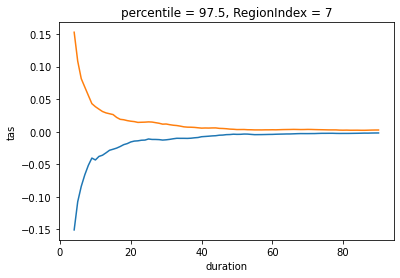

In [14]:
RegionIndex = 7

obsle_ipccregion_trends_percentiles['tas'].sel(RegionIndex=RegionIndex,percentile=2.5).plot()
obsle_ipccregion_trends_percentiles['tas'].sel(RegionIndex=RegionIndex,percentile=97.5).plot()

In [15]:
del obsle_ipccregion_trends_percentiles,obsle_pic_trends_2_5perc,obsle_pic_trends_97_5perc,obsle_ipcc_trends_all

### Compute trend percentiles (spatial 5x5 deg.)

New approach

In [16]:
# obsle_spatial_trends_all = xr.open_mfdataset(obsle_5x5_trend_filepath,chunks={'startyear':-1,'samples':-1}).rename({'TREFHT':'tas'})
obsle_spatial_trends_all = xr.open_dataarray(*obsle_5x5_trend_filepath2,chunks={'startyear':-1,'samples':-1,'duration':1}).rename('tas')


In [17]:
obsle_spatial_trends_all

,Array,Chunk
Bytes,3.61 GB,41.47 MB
Shape,"(2, 87, 1000, 36, 72)","(2, 1, 1000, 36, 72)"
Count,88 Tasks,87 Chunks
Type,float64,numpy.ndarray


It turns out that using the entire data is better than using the poorly chunked data :welp:

In [18]:
%%time

percs_by_dur = []
for _dur in obsle_spatial_trends_all.duration:
    
    print(_dur.values,end=' ')
    
    _dur_subset = obsle_spatial_trends_all.sel(duration=_dur)
    
    _obsle_pic_trends5x5_2_5perc = percentile_vec_mult(_dur_subset,q=2.5,core_dims=['startyear','samples']).compute()
    _obsle_pic_trends5x5_97_5perc = percentile_vec_mult(_dur_subset,q=97.5,core_dims=['startyear','samples']).compute()
        
    obsle_spatial_trends_percentiles = xr.merge([_obsle_pic_trends5x5_2_5perc.assign_coords({'percentile':2.5}).expand_dims('percentile',axis=-1),
                                                 _obsle_pic_trends5x5_97_5perc.assign_coords({'percentile':97.5}).expand_dims('percentile',axis=-1)])
    
    percs_by_dur.append(obsle_spatial_trends_percentiles)
    
    # if _dur.values == 10:
    #     break
    
all_perc = xr.concat(percs_by_dur,dim='duration')

4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 CPU times: user 45.1 s, sys: 3.74 s, total: 48.9 s
Wall time: 1min 10s


In [20]:
obsle_spatial_trends_percentiles = all_perc

filename = 'TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1922.Percentiles.nc' % _dur.values

obsle_spatial_trends_percentiles.to_netcdf('%s/%s' % (obsle_tseries_dir,filename))

There is no obvious ENSO signal in variability in the tropical pacific.

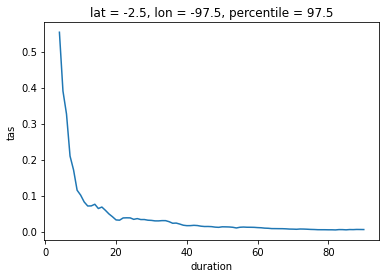

In [19]:
all_perc['tas'].isel(percentile=1,lat=17,lon=16).plot()

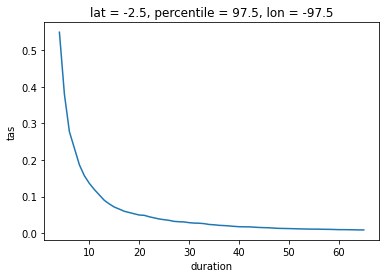

In [50]:
all_perc['tas'].isel(percentile=1,lat=17,lon=16).plot()

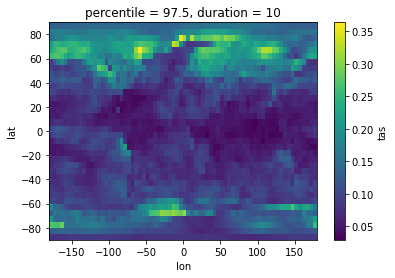

In [21]:
obsle_spatial_trends_percentiles['tas'].sel(percentile=97.5,duration=10).plot() #.isel(lat=5,lon=5)